# Obtaining and evaluation of patient representations 

## Install the patient_representation package

In [ ]:
!pip install git+https://github.com/lueckenlab/patient_representation.git@main

## Import packages

In [30]:
import ehrapy as ep
import pandas as pd
import numpy as np
import scanpy as sc
import patient_representation as pr
import matplotlib.pyplot as plt
import seaborn as sns
from plottable import ColumnDefinition, Table
from plottable.cmap import normed_cmap
from plottable.plots import bar
import matplotlib
from matplotlib.colors import LinearSegmentedColormap


In [31]:
pr.__version__

'0.1.21'

## Read the data

I will use [COMBAT dataset](https://www.kaggle.com/datasets/shitovvladimir/a-blood-atlas-of-covid-19-combat-preprocessed). You can set your own path

In [32]:
ADATA_PATH = "/Users/farhad/helmholtz/patpy/combat_processed.h5ad"

In [34]:
adata = sc.read_h5ad(ADATA_PATH)
adata

AnnData object with n_obs × n_vars = 783704 × 3000
    obs: 'Annotation_cluster_id', 'Annotation_cluster_name', 'Annotation_minor_subset', 'Annotation_major_subset', 'Annotation_cell_type', 'GEX_region', 'QC_ngenes', 'QC_total_UMI', 'QC_pct_mitochondrial', 'QC_scrub_doublet_scores', 'TCR_chain_composition', 'TCR_clone_ID', 'TCR_clone_count', 'TCR_clone_proportion', 'TCR_contains_unproductive', 'TCR_doublet', 'TCR_chain_TRA', 'TCR_v_gene_TRA', 'TCR_d_gene_TRA', 'TCR_j_gene_TRA', 'TCR_c_gene_TRA', 'TCR_productive_TRA', 'TCR_cdr3_TRA', 'TCR_umis_TRA', 'TCR_chain_TRA2', 'TCR_v_gene_TRA2', 'TCR_d_gene_TRA2', 'TCR_j_gene_TRA2', 'TCR_c_gene_TRA2', 'TCR_productive_TRA2', 'TCR_cdr3_TRA2', 'TCR_umis_TRA2', 'TCR_chain_TRB', 'TCR_v_gene_TRB', 'TCR_d_gene_TRB', 'TCR_j_gene_TRB', 'TCR_c_gene_TRB', 'TCR_productive_TRB', 'TCR_chain_TRB2', 'TCR_v_gene_TRB2', 'TCR_d_gene_TRB2', 'TCR_j_gene_TRB2', 'TCR_c_gene_TRB2', 'TCR_productive_TRB2', 'TCR_cdr3_TRB2', 'TCR_umis_TRB2', 'BCR_umis_HC', 'BCR_contig_qc_HC

In [43]:
adata.layers["raw"].shape

In [44]:
pr.pp.is_count_data(adata.layers["raw"])

True

## Describe columns containing sample IDs, cell types and metadata

In [5]:
sample_id_col = "scRNASeq_sample_ID"
cell_type_key = "Annotation_major_subset"
samples_metadata_cols = ["Source", "Outcome", "Death28", "Institute", "Pool_ID"]

## Store metadata and calculate QC metrics

In [6]:
metadata = adata.obs[samples_metadata_cols + [sample_id_col]].drop_duplicates()
metadata.set_index(sample_id_col, inplace=True)
metadata

,Source,Outcome,Death28,Institute,Pool_ID
scRNASeq_sample_ID,,,,,
S00109-Ja001E-PBCa,COVID_SEV,2.0,0,Oxford,gPlexA
S00112-Ja003E-PBCa,COVID_MILD,5.0,0,Oxford,gPlexA
S00005-Ja005E-PBCa,COVID_CRIT,2.0,0,Oxford,gPlexA
S00061-Ja003E-PBCa,COVID_SEV,4.0,0,Oxford,gPlexA
S00056-Ja003E-PBCa,COVID_SEV,3.0,0,Oxford,gPlexA
...,...,...,...,...,...
S00065-Ja003E-PBCa,COVID_CRIT,2.0,0,Oxford,gPlexK
S00048-Ja003E-PBCa,COVID_SEV,4.0,0,Oxford,gPlexK
G05112-Ja005E-PBCa,COVID_HCW_MILD,6.0,0,Oxford,gPlexK


In [7]:
cell_qc_metadata = pr.pp.calculate_cell_qc_metrics(adata, sample_key=sample_id_col, cell_qc_vars=["QC_ngenes", "QC_pct_mitochondrial", "QC_scrub_doublet_scores"])
cell_qc_metadata

,median_QC_ngenes,median_QC_pct_mitochondrial,median_QC_scrub_doublet_scores
scRNASeq_sample_ID,,,
G05061-Ja005E-PBCa,1107.0,3.011159,0.050648
G05064-Ja005E-PBCa,975.0,1.332430,0.060894
G05073-Ja005E-PBCa,1141.0,2.422559,0.044530
G05077-Ja005E-PBCa,1125.0,2.946723,0.048490
G05078-Ja005E-PBCa,999.0,2.825308,0.052783
...,...,...,...
U00607-Ua005E-PBUa,1827.0,2.982509,0.043323
U00613-Ua005E-PBUa,1251.5,2.053083,0.036956
U00617-Ua005E-PBUa,1410.5,3.886215,0.057906


In [8]:
n_genes_metadata = pr.pp.calculate_n_cells_per_sample(adata, sample_id_col)
n_genes_metadata

,n_cells
S00052-Ja005E-PBCa,13918
H00054-Ha001E-PBGa,10938
H00067-Ha001E-PBGa,10781
N00023-Ja001E-PBGa,10484
H00053-Ha001E-PBGa,10458
...,...
U00701-Ua005E-PBUa,872
U00601-Ua005E-PBUa,619
U00504-Ua005E-PBUa,161
G05092-Ja005E-PBCa,16


In [9]:
composition_metadata = pr.pp.calculate_compositional_metrics(adata, sample_id_col, [cell_type_key], normalize_to=100)
composition_metadata

/Users/farhad/miniconda3/envs/pt/lib/python3.10/site-packages/pandas/core/indexes/multi.py:643: DeprecationWarning: `cumproduct` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `cumprod` instead.
  codes = cartesian_product(codes)
/Users/farhad/miniconda3/envs/pt/lib/python3.10/site-packages/pandas/core/reshape/util.py:60: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  return [
/Users/farhad/miniconda3/envs/pt/lib/python3.10/site-packages/pandas/core/reshape/util.py:60: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  return [


Annotation_major_subset,Annotation_major_subset_B,Annotation_major_subset_CD4,Annotation_major_subset_CD8,Annotation_major_subset_DC,Annotation_major_subset_DN,Annotation_major_subset_DP,Annotation_major_subset_GDT,Annotation_major_subset_HSC,Annotation_major_subset_MAIT,Annotation_major_subset_Mast,Annotation_major_subset_NK,Annotation_major_subset_PB,Annotation_major_subset_PLT,Annotation_major_subset_RET,Annotation_major_subset_cMono,Annotation_major_subset_iNKT,Annotation_major_subset_ncMono
scRNASeq_sample_ID,,,,,,,,,,,,,,,,,
G05061-Ja005E-PBCa,6.324900,33.921438,12.366844,1.597870,0.532623,0.499334,0.898802,0.066578,4.677097,0.000000,18.159121,0.316245,0.166445,0.016644,15.812250,0.033289,4.610519
G05064-Ja005E-PBCa,3.405158,47.147482,16.400581,1.819806,1.228090,0.725689,2.188233,0.022329,1.317405,0.000000,7.457854,0.446578,0.000000,0.000000,14.357486,0.000000,3.483309
G05073-Ja005E-PBCa,5.194338,45.609405,16.278791,1.487524,1.247601,0.839731,4.654511,0.011996,2.195298,0.011996,3.730806,0.203935,0.047985,0.000000,13.963532,0.083973,4.438580
G05077-Ja005E-PBCa,5.846211,29.231056,14.596909,1.377770,0.446844,1.340532,0.465463,0.167567,0.800596,0.018619,22.844908,1.079873,0.074474,0.018619,18.004096,0.055856,3.630609
G05078-Ja005E-PBCa,1.366381,39.000106,15.591569,2.340854,0.762631,0.730855,2.648025,0.211842,1.737104,0.021184,10.666243,0.148289,0.021184,0.000000,19.521237,0.497829,4.734668
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
U00607-Ua005E-PBUa,3.623898,10.577865,1.273262,4.701273,0.097943,0.195886,0.195886,0.685602,0.097943,0.000000,5.876592,1.175318,1.958864,0.097943,37.904016,0.000000,31.537708
U00613-Ua005E-PBUa,7.835052,26.391753,16.907216,0.721649,0.412371,0.309278,1.649485,0.000000,0.103093,0.000000,5.154639,1.237113,0.206186,0.000000,37.938144,0.000000,1.134021
U00617-Ua005E-PBUa,2.977233,41.418564,16.462347,0.437828,0.525394,0.262697,0.262697,0.963222,0.087566,0.000000,7.530648,17.513135,0.788091,0.087566,9.719790,0.000000,0.963222


Merge metadata tables

In [10]:
metadata = pd.concat([
    metadata,
    cell_qc_metadata.loc[metadata.index],
    n_genes_metadata.loc[metadata.index],
    composition_metadata.loc[metadata.index]
], axis=1)

In [11]:
metadata.shape

## Run a simple pseudobulk representation

In [12]:
adata

AnnData object with n_obs × n_vars = 783704 × 3000
    obs: 'Annotation_cluster_id', 'Annotation_cluster_name', 'Annotation_minor_subset', 'Annotation_major_subset', 'Annotation_cell_type', 'GEX_region', 'QC_ngenes', 'QC_total_UMI', 'QC_pct_mitochondrial', 'QC_scrub_doublet_scores', 'TCR_chain_composition', 'TCR_clone_ID', 'TCR_clone_count', 'TCR_clone_proportion', 'TCR_contains_unproductive', 'TCR_doublet', 'TCR_chain_TRA', 'TCR_v_gene_TRA', 'TCR_d_gene_TRA', 'TCR_j_gene_TRA', 'TCR_c_gene_TRA', 'TCR_productive_TRA', 'TCR_cdr3_TRA', 'TCR_umis_TRA', 'TCR_chain_TRA2', 'TCR_v_gene_TRA2', 'TCR_d_gene_TRA2', 'TCR_j_gene_TRA2', 'TCR_c_gene_TRA2', 'TCR_productive_TRA2', 'TCR_cdr3_TRA2', 'TCR_umis_TRA2', 'TCR_chain_TRB', 'TCR_v_gene_TRB', 'TCR_d_gene_TRB', 'TCR_j_gene_TRB', 'TCR_c_gene_TRB', 'TCR_productive_TRB', 'TCR_chain_TRB2', 'TCR_v_gene_TRB2', 'TCR_d_gene_TRB2', 'TCR_j_gene_TRB2', 'TCR_c_gene_TRB2', 'TCR_productive_TRB2', 'TCR_cdr3_TRB2', 'TCR_umis_TRB2', 'BCR_umis_HC', 'BCR_contig_qc_HC

In [13]:
pseudobulk = pr.tl.TotalPseudobulk(sample_key=sample_id_col, cells_type_key=cell_type_key, layer="X_scVI")
pseudobulk.prepare_anndata(
    adata,
    sample_size_threshold=100,  # Samples with less cells are filtered out
    cluster_size_threshold=0  # Cell types with less cels in at least one sample are filtered out
)

2 samples removed: G05092-Ja005E-PBCa, S00030-Ja003E-PBCa


/Users/farhad/miniconda3/envs/pt/lib/python3.10/site-packages/pandas/core/algorithms.py:522: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  common = np.find_common_type([values.dtype, comps_array.dtype], [])


0 cell types removed: 


/Users/farhad/miniconda3/envs/pt/lib/python3.10/site-packages/pandas/core/algorithms.py:522: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  common = np.find_common_type([values.dtype, comps_array.dtype], [])


## Calculate a matrix of distances between samples

In [14]:
distances = pseudobulk.calculate_distance_matrix()
distances

array([[0.        , 1.64099831, 2.96553122, ..., 1.95250026, 3.03192841,
        3.02217346],
       [1.64099831, 0.        , 2.12407907, ..., 2.16392363, 2.62691869,
        2.25420939],
       [2.96553122, 2.12407907, 0.        , ..., 3.22771463, 2.59879782,
        1.26095859],
       ...,
       [1.95250026, 2.16392363, 3.22771463, ..., 0.        , 2.58964553,
        3.24267928],
       [3.03192841, 2.62691869, 2.59879782, ..., 2.58964553, 0.        ,
        2.38191478],
       [3.02217346, 2.25420939, 1.26095859, ..., 3.24267928, 2.38191478,
        0.        ]])

In [15]:
pseudobulk.patient_representations

array([[ 0.07022396, -0.81861651,  0.02322182, ...,  0.00632453,
         0.02928598, -0.71011758],
       [ 0.2963993 , -0.31120506, -0.15302308, ...,  0.02531394,
        -0.05384022, -0.25963679],
       [ 0.08746515, -0.24343272, -0.118353  , ...,  0.04432571,
        -0.32196337, -0.53503102],
       ...,
       [ 0.28494811, -0.21990822, -0.07117738, ...,  0.33443618,
        -0.28370655, -0.23191516],
       [-0.25188622,  0.04033372, -0.3371191 , ...,  0.32684869,
        -0.34542695, -0.24013592],
       [-0.39771539, -0.35274509,  0.53162658, ...,  0.01920659,
        -0.21306472, -0.44230187]])

/Users/farhad/miniconda3/envs/pt/lib/python3.10/site-packages/pandas/core/algorithms.py:522: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  common = np.find_common_type([values.dtype, comps_array.dtype], [])
/Users/farhad/miniconda3/envs/pt/lib/python3.10/site-packages/pandas/core/algorithms.py:522: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  common = np.find_common_type([values.dtype, comps_array.dtype], [])
/Users/farhad/miniconda3/envs/pt/lib/python3.10/site-packages/pandas/core/algorithms.py:522: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdoc

array([<Axes: xlabel='UMAP_0', ylabel='UMAP_1'>,
       <Axes: xlabel='UMAP_0', ylabel='UMAP_1'>,
       <Axes: xlabel='UMAP_0', ylabel='UMAP_1'>,
       <Axes: xlabel='UMAP_0', ylabel='UMAP_1'>,
       <Axes: xlabel='UMAP_0', ylabel='UMAP_1'>], dtype=object)

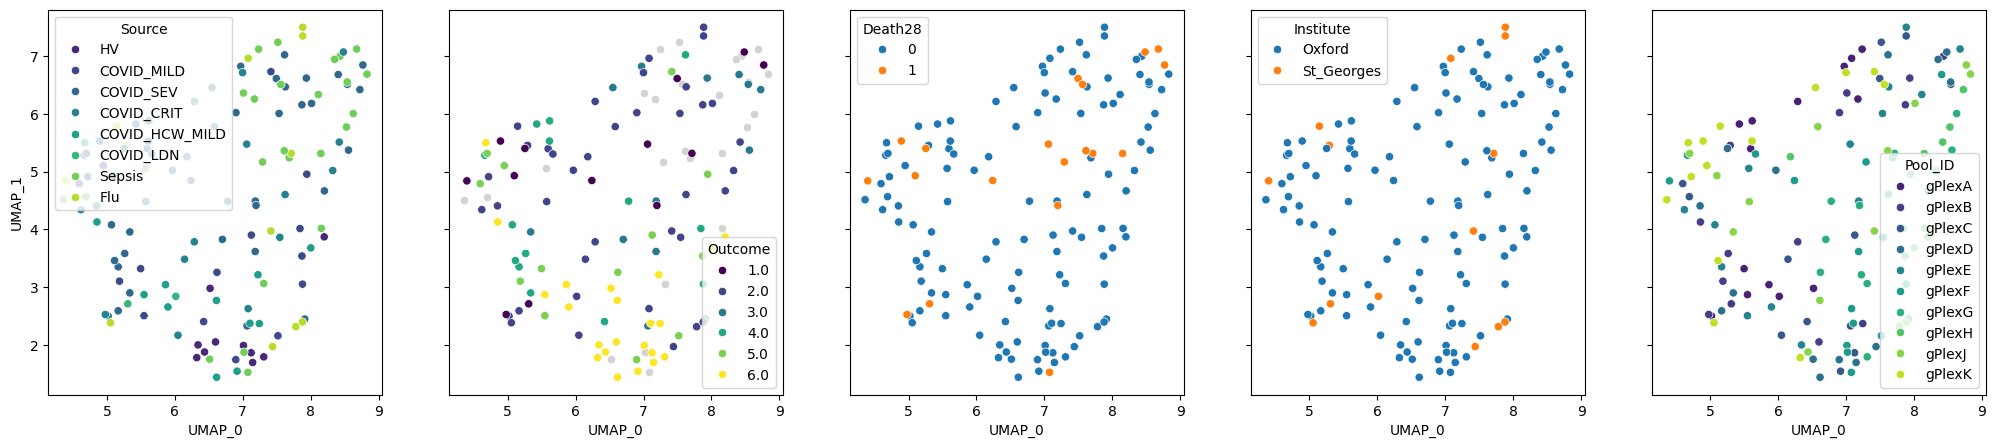

In [16]:
pseudobulk.plot_embedding(method="UMAP", metadata_cols=samples_metadata_cols)

Other dimensionality reduction methods are also available

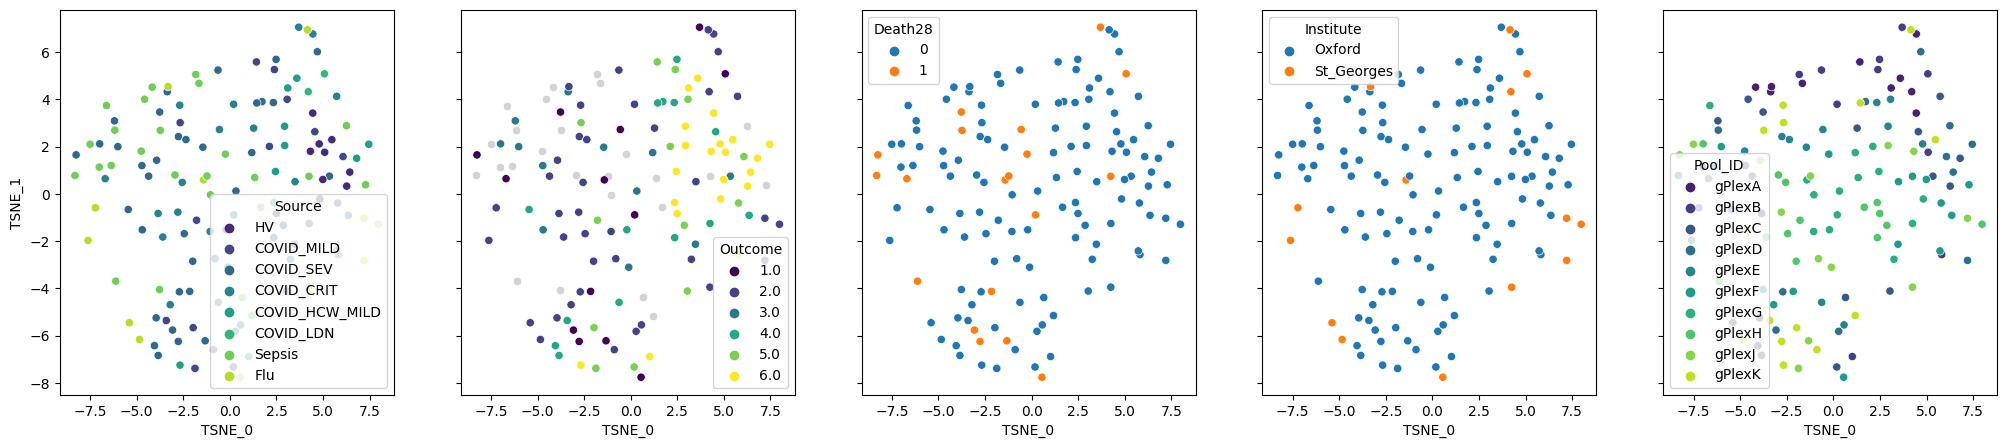

In [18]:
pseudobulk.plot_embedding(method="TSNE", metadata_cols=samples_metadata_cols);

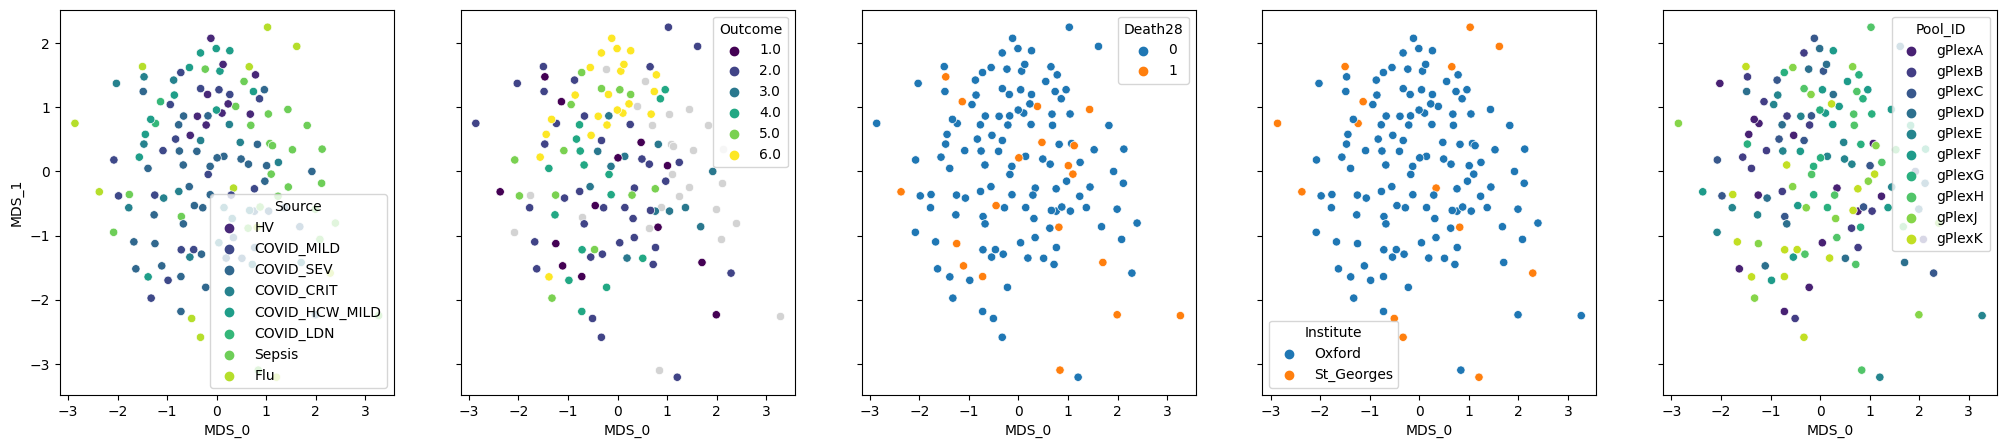

In [19]:
pseudobulk.plot_embedding(method="MDS", metadata_cols=samples_metadata_cols);

### Evaluate how well a covariate is represented

Let's try to classify "Outcome" based on the nearest neighbors of the patients:

In [17]:
pseudobulk.evaluate_representation(target="Outcome", method="knn", n_neighbors=5, task="classification")

/Users/farhad/miniconda3/envs/pt/lib/python3.10/site-packages/pandas/core/algorithms.py:522: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  common = np.find_common_type([values.dtype, comps_array.dtype], [])


{'score': 0.1765933894987563,
 'metric': 'f1_macro_calibrated',
 'n_unique': 6,
 'n_observations': 113,
 'method': 'knn'}

It doesn't work too good. Now we can try to solve the ranking problem for the same covariate. It will train regressor and use a different metric for evaluation:

In [21]:
pseudobulk.evaluate_representation(target="Outcome", method="knn", n_neighbors=5, task="ranking")

{'score': 0.5229921267759305,
 'metric': 'spearman_r',
 'n_unique': 6,
 'n_observations': 113,
 'method': 'knn'}

Now let's see how well Pool is represented:

In [22]:
pseudobulk.evaluate_representation(target="Pool_ID", method="knn", n_neighbors=5, task="classification")

{'score': 0.3090079143336576,
 'metric': 'f1_macro_calibrated',
 'n_unique': 10,
 'n_observations': 138,
 'method': 'knn'}

Save the distances to adata

In [17]:
adata.uns["pseudobulk_distances"] = distances
adata.uns["pseudobulk_samples"] = pseudobulk.samples
adata.uns["pseudobulk_UMAP"] = pseudobulk.embeddings["UMAP"]

## Run PILOT representation

In [18]:
pilot = pr.tl.PILOT(
    sample_key=sample_id_col,
    cells_type_key=cell_type_key,
    layer="X_scVI",
    patient_state_col="Outcome"  # It is not used for distances calculation and doesn't really matter
)

In [19]:
pilot.prepare_anndata(adata, sample_size_threshold=100)

2 samples removed: G05092-Ja005E-PBCa, S00030-Ja003E-PBCa


/Users/farhad/miniconda3/envs/pt/lib/python3.10/site-packages/pandas/core/algorithms.py:522: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  common = np.find_common_type([values.dtype, comps_array.dtype], [])


0 cell types removed: 


/Users/farhad/miniconda3/envs/pt/lib/python3.10/site-packages/pandas/core/algorithms.py:522: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  common = np.find_common_type([values.dtype, comps_array.dtype], [])


In [20]:
pilot.calculate_distance_matrix()

array([[0.        , 0.15108545, 0.43541713, ..., 0.1113311 , 0.21055699,
        0.38776141],
       [0.15108545, 0.        , 0.31687854, ..., 0.10428505, 0.1189053 ,
        0.26105924],
       [0.43541713, 0.31687854, 0.        , ..., 0.37342266, 0.24217094,
        0.07748679],
       ...,
       [0.1113311 , 0.10428505, 0.37342266, ..., 0.        , 0.16653737,
        0.32326736],
       [0.21055699, 0.1189053 , 0.24217094, ..., 0.16653737, 0.        ,
        0.2215235 ],
       [0.38776141, 0.26105924, 0.07748679, ..., 0.32326736, 0.2215235 ,
        0.        ]])

array([<Axes: xlabel='UMAP_0', ylabel='UMAP_1'>,
       <Axes: xlabel='UMAP_0', ylabel='UMAP_1'>,
       <Axes: xlabel='UMAP_0', ylabel='UMAP_1'>,
       <Axes: xlabel='UMAP_0', ylabel='UMAP_1'>,
       <Axes: xlabel='UMAP_0', ylabel='UMAP_1'>], dtype=object)

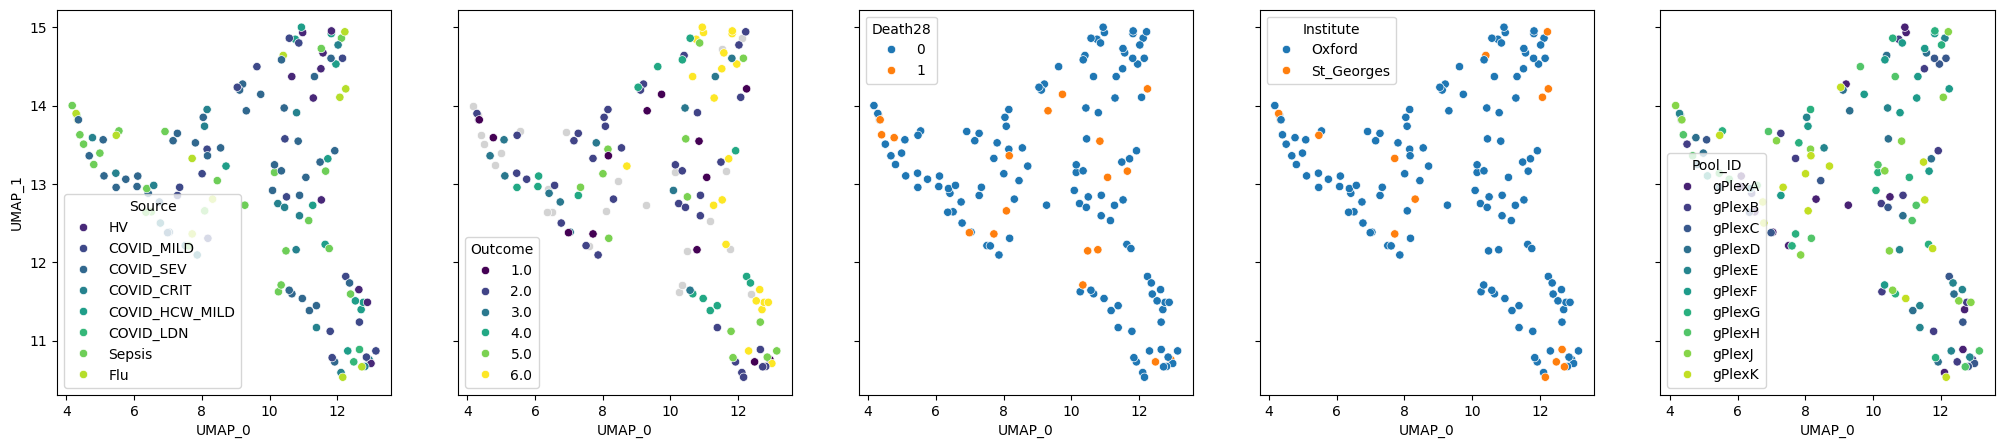

In [21]:
pilot.plot_embedding(method="UMAP", metadata_cols=samples_metadata_cols)

In [22]:
adata.uns["pilot_distances"] = pilot.calculate_distance_matrix()
adata.uns["pilot_samples"] = pilot.samples
adata.uns["pilot_UMAP"] = pilot.embeddings["UMAP"]

Let's check the covariates:

In [23]:
pilot.evaluate_representation(target="Outcome", method="knn", n_neighbors=5, task="ranking")

{'score': 0.4578010780721651,
 'metric': 'spearman_r',
 'n_unique': 6,
 'n_observations': 113,
 'method': 'knn'}

In [30]:
pilot.evaluate_representation(target="Pool_ID", method="knn", n_neighbors=5, task="classification")

{'score': 0.011946569888727821,
 'metric': 'f1_macro_calibrated',
 'n_unique': 10,
 'n_observations': 138,
 'method': 'knn'}

Outcome is represented a bit worse, but Pool ID almost doesn't affect the representation

# Compare representations

In [31]:
def align_representations(adata, meta_adata, samples, methods, cols_of_interest):
    for method in methods:
    #     samples_to_take = np.isin(adata.uns[f"{method}_samples"], samples)
        representation_samples = adata.uns[f"{method}_samples"].tolist()
        samples_order = [representation_samples.index(sample) for sample in samples if sample in representation_samples]

        assert (adata.uns[f"{method}_samples"][samples_order] == samples).all(), "Order of samples is not correct"

        meta_adata.obsm[f"{method}_UMAP"] = adata.uns[f"{method}_UMAP"][samples_order]
        meta_adata.obsm["umap"] = meta_adata.obsm[f"{method}_UMAP"]
        meta_adata.obsm[f"{method}_distances"] = adata.uns[f"{method}_distances"][samples_order][:, samples_order]

        ep.pp.neighbors(meta_adata, use_rep=f"{method}_distances", key_added=f"{method}_neighbors", metric="precomputed")
        ep.tl.leiden(meta_adata, key_added=f"{method}_leiden", neighbors_key=f"{method}_neighbors")

        fig = ep.pl.umap(meta_adata, color=[f"{method}_leiden"] + cols_of_interest, return_fig=True)
        fig.suptitle(method, fontsize=20)

    return meta_adata

In [32]:
combat_methods = [
    "pseudobulk",
    "pilot",
]

In [33]:
combat_samples = list(set(adata.uns[f"{method}_samples"]) for method in combat_methods)
combat_samples = list(set.intersection(*combat_samples))
len(combat_samples)

In [34]:
metadata = metadata.loc[combat_samples]

In [35]:
combat_meta_adata = ep.io.df_to_anndata(metadata)
combat_meta_adata = ep.pp.encode(combat_meta_adata, autodetect=True)
combat_meta_adata

2023-10-27 13:27:28,735 - root INFO - Added all columns to `obs`.
2023-10-27 13:27:28,740 - root INFO - Transformed passed dataframe into an AnnData object with n_obs x n_vars = `138` x `26`.
2023-10-27 13:27:28,740 - root INFO - The original categorical values `['Pool_ID', 'Source', 'Institute']` were added to uns.


Output()

2023-10-27 13:27:28,747 - root INFO - Encoding strings in X to save to .h5ad. Loading the file will reverse the encoding.


2023-10-27 13:27:28,749 - root INFO - Updated the original layer after encoding.


2023-10-27 13:27:28,752 - root INFO - The original categorical values `['Pool_ID', 'Source', 'Institute']` were added to obs.


AnnData object with n_obs × n_vars = 138 × 26
    obs: 'Source', 'Institute', 'Pool_ID'
    uns: 'numerical_columns', 'non_numerical_columns', 'original_values_categoricals', 'var_to_encoding', 'encoding_to_var', 'encoded_non_numerical_columns'
    layers: 'original'

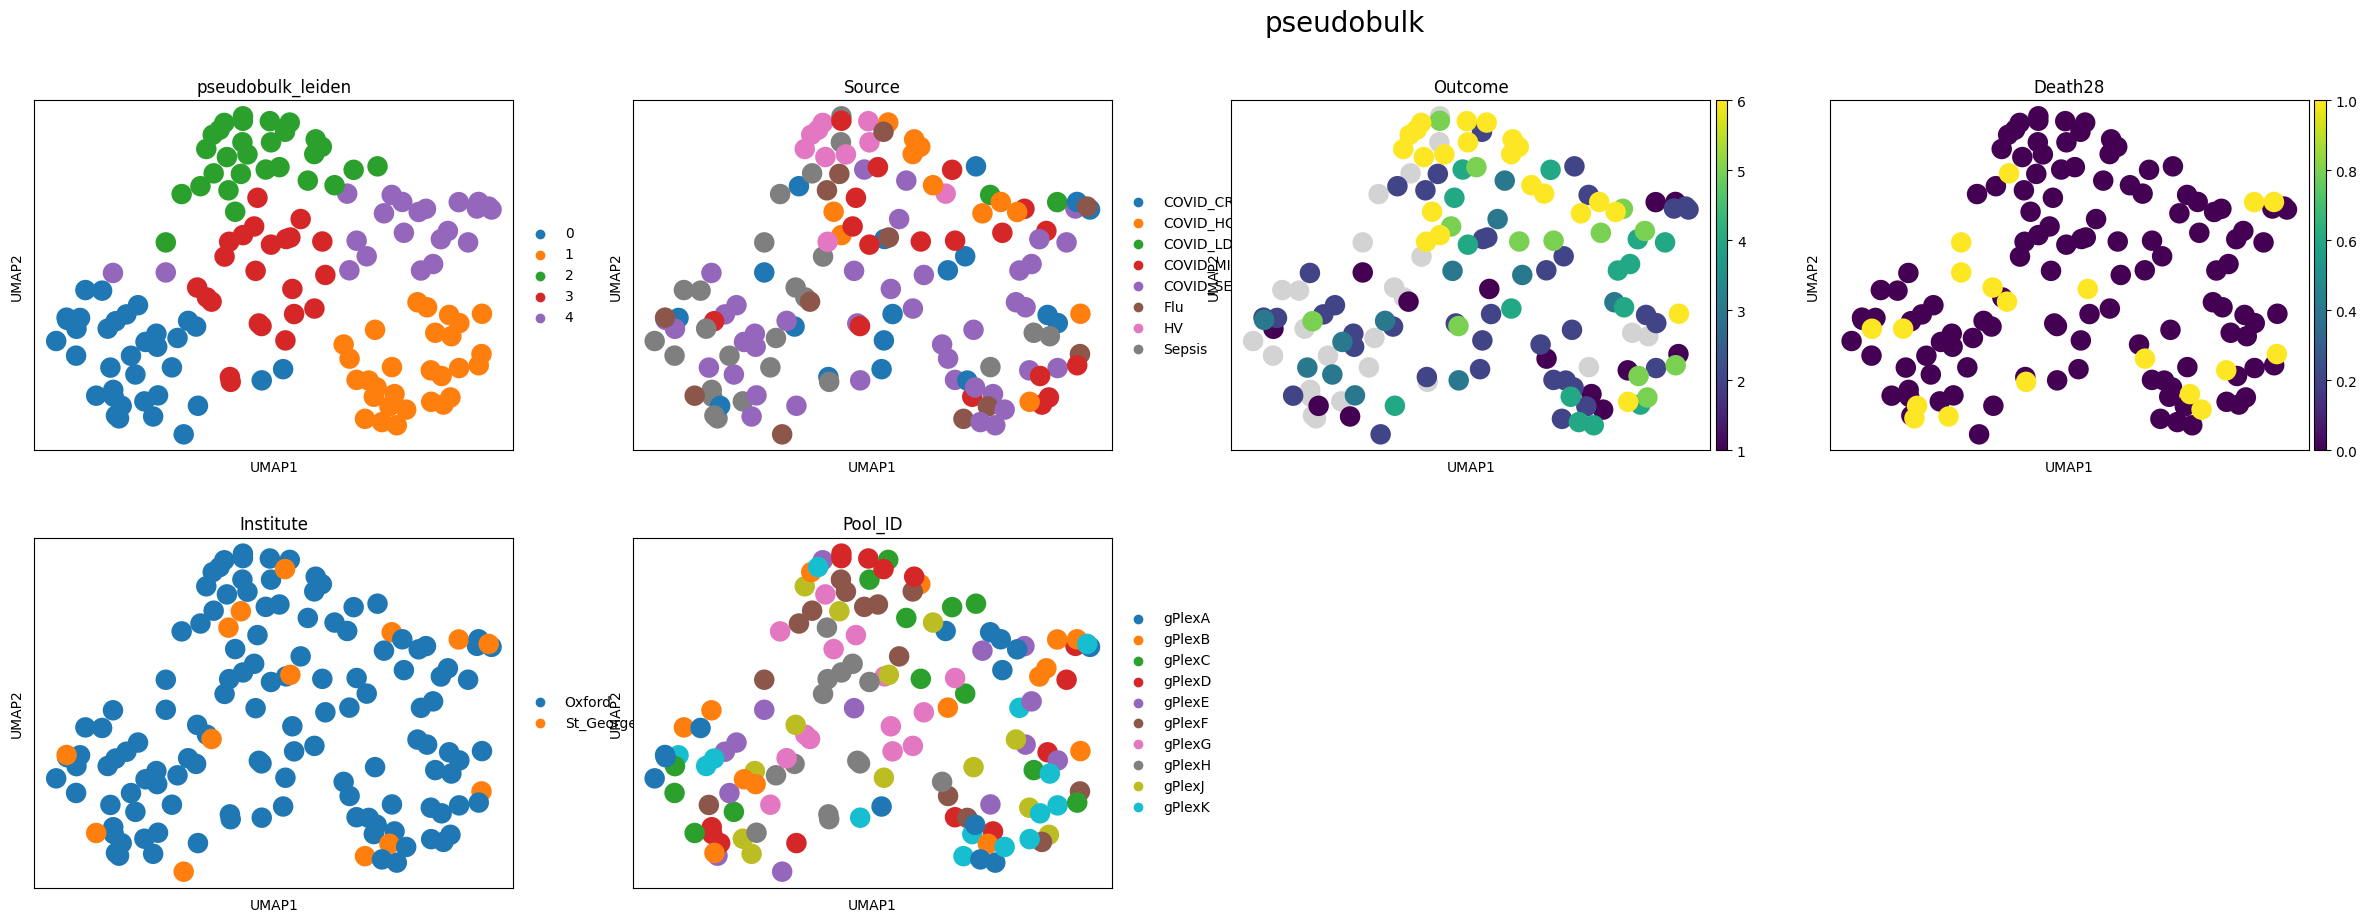

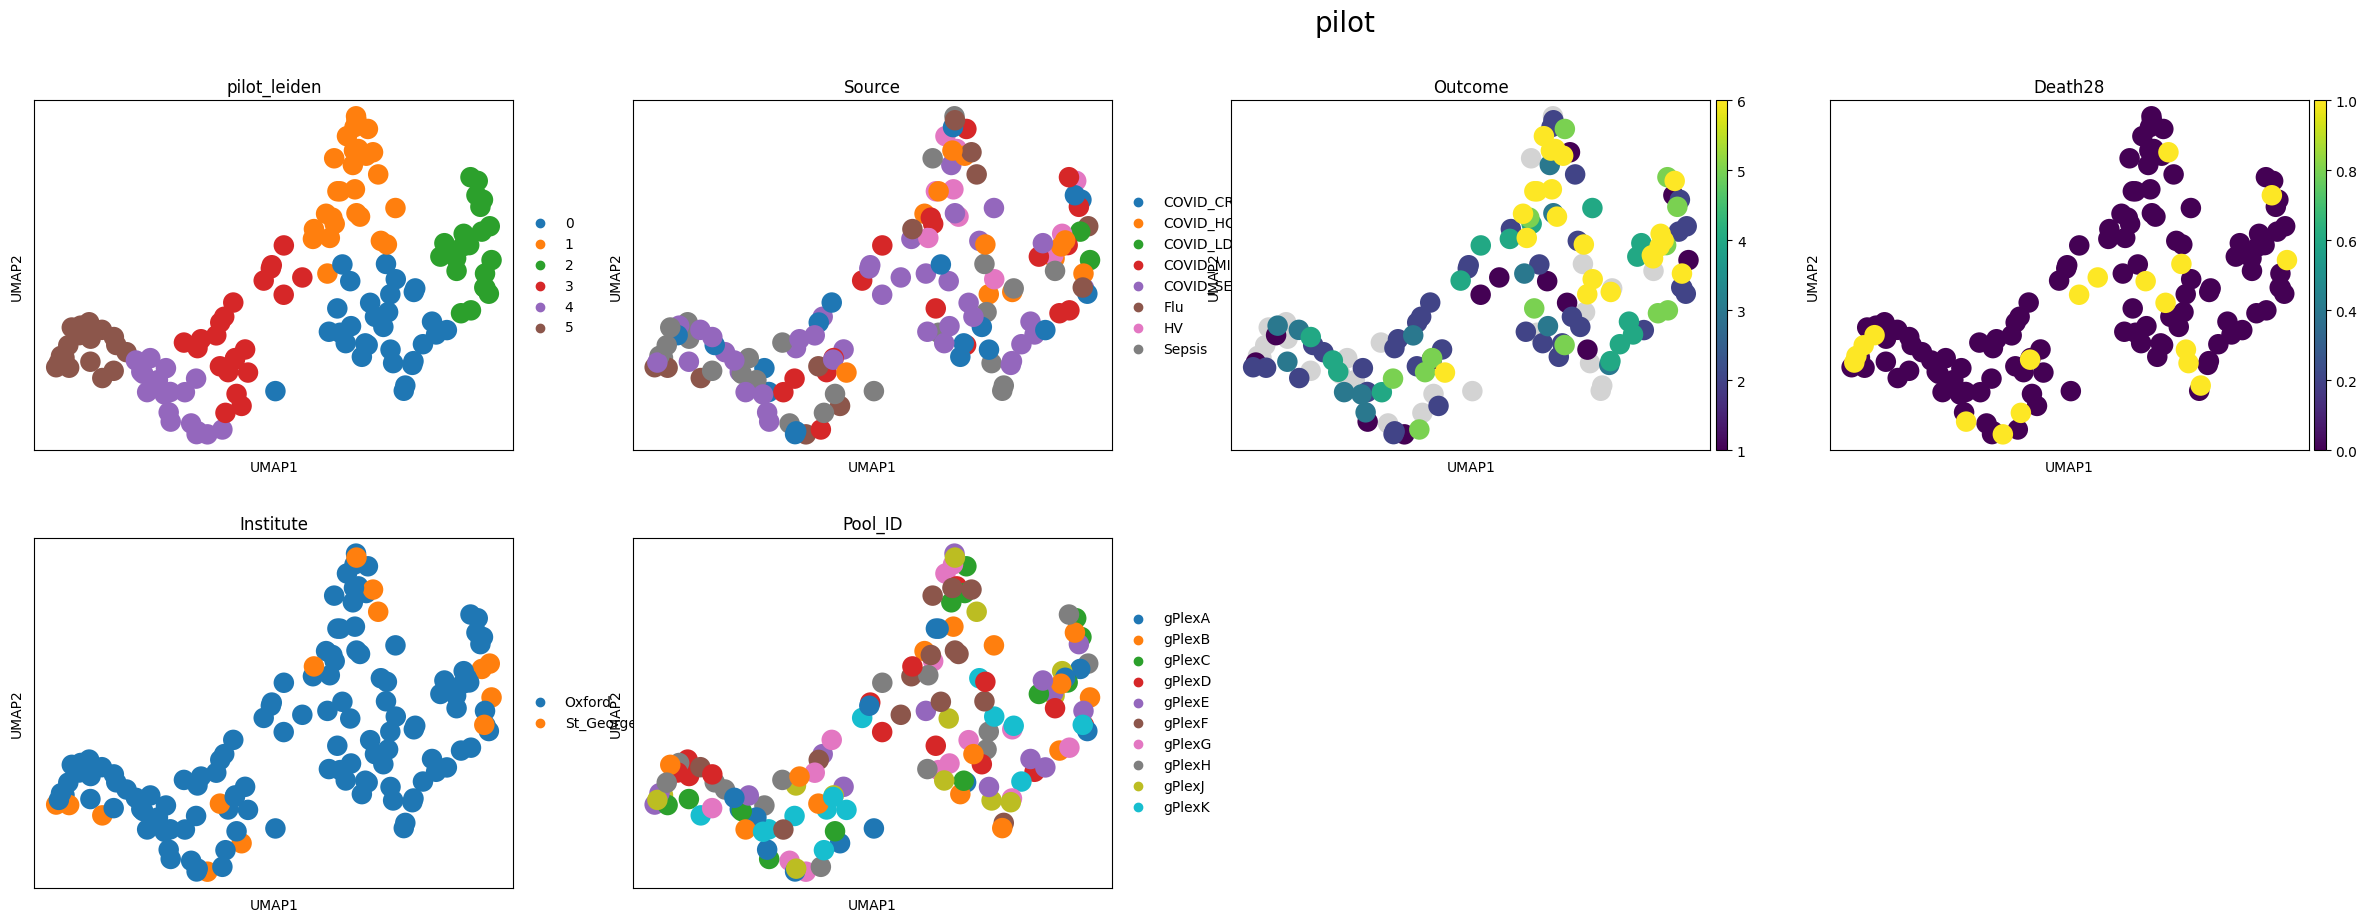

In [36]:
combat_meta_adata = align_representations(adata=adata, meta_adata=combat_meta_adata, samples=combat_samples, methods=combat_methods, cols_of_interest=samples_metadata_cols)

## Define types and prediction tasks for the covariates

In [37]:
benchmark_schema = {
    "technical": ["Institute", "Pool_ID", "n_cells", "median_QC_ngenes"],
    "clinical": ["Death28", "Outcome", "Source"],
    "biological": ["Annotation_major_subset_CD4"],
}

cols_with_tasks = {
    "Annotation_major_subset_CD4": "regression",
    "Institute": "classification",
    "Pool_ID": "classification",
    "n_cells": "regression",
    "median_QC_ngenes": "regression",
    "Death28": "classification",
    "Outcome": "ranking",
    "Source": "classification",
}

In [38]:
results = []

for method in combat_methods: 
    for covariate_type in benchmark_schema:
        for col in benchmark_schema[covariate_type]:
            task = cols_with_tasks[col]
            try:
                result = pr.tl.evaluate_representation(
                    distances=combat_meta_adata.obsm[f"{method}_distances"],
                    target=metadata[col],
                    method="knn",
                    task=task,
        #             n_neighbors=5
                )
            except Exception as e:
                print("Method:", method)
                print("Col:", col)
                print("Task:", task)
                print(e)
                print()
                continue
    #             raise(e)
            result["representation"] = method
            result["covariate"] = col
            result["covariate_type"] = covariate_type
            
            if result["metric"] == "spearman_r":
                result["score"] = abs(result["score"])
            
            if covariate_type == "technical":
                result["score"] = 1 - result["score"]
            
            results.append(result)

Scores are ranged from 0 to 1

- For covariates that we defined as technical, 0 means that covariate strongly affects the representation, and 1 means that this covariate is randomly distributed across representation
- For biological and clinical covariates, 0 means that a covariate is not represented well (it is randomly distributed), while 1 means that similar patients have similar values of covariate 

In [39]:
knn_results = pd.DataFrame(results)
knn_results.sort_values("score", ascending=False)

,score,metric,n_unique,n_observations,method,representation,covariate,covariate_type
9,1.000000,f1_macro_calibrated,10,138,knn,pilot,Pool_ID,technical
15,0.968410,spearman_r,138,138,knn,pilot,Annotation_major_subset_CD4,biological
8,0.940268,f1_macro_calibrated,2,138,knn,pilot,Institute,technical
0,0.928846,f1_macro_calibrated,2,138,knn,pseudobulk,Institute,technical
7,0.840142,spearman_r,138,138,knn,pseudobulk,Annotation_major_subset_CD4,biological
10,0.805007,spearman_r,138,138,knn,pilot,n_cells,technical
2,0.765412,spearman_r,138,138,knn,pseudobulk,n_cells,technical
11,0.693967,spearman_r,119,138,knn,pilot,median_QC_ngenes,technical
1,0.691703,f1_macro_calibrated,10,138,knn,pseudobulk,Pool_ID,technical
5,0.493732,spearman_r,6,113,knn,pseudobulk,Outcome,clinical


Text(0.5, 1.0, 'KNN-score')

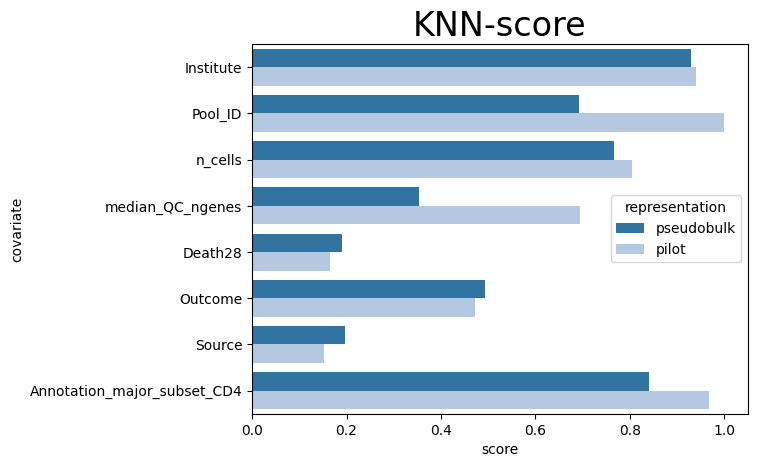

In [40]:
# plt.figure(figsize=(10, 20))
sns.barplot(data=knn_results, y="covariate", x="score", orient="h", hue="representation", palette="tab20")
plt.xlim(0, 1.05)
plt.title("KNN-score", fontsize=24)

In [41]:
knn_results_wide = knn_results.pivot(index="representation", columns="covariate", values="score")
# knn_results_wide.reset_index(inplace=True)

# Order the columns as in benchmark schema
cols_order = ["total"]

for covariate_type in benchmark_schema:
    cols_order.extend(benchmark_schema[covariate_type])
    cols_order.append(covariate_type)

cmap = LinearSegmentedColormap.from_list(
    name="bugw", colors=["#FF9693", "#f2fbd2", "#c9ecb4", "#93d3ab", "#35b0ab"], N=256
)

col_defs = []

col_defs.append(
    ColumnDefinition(
        "total",
        width=0.7,
        plot_fn=bar,
        plot_kw={
            "cmap": cmap,
            "plot_bg_bar": True,
            "annotate": True,
            "height": 0.5,
            "lw": 0.5,
            "formatter": lambda x: round(x, 2),
        })
)

for covariate_type in benchmark_schema:
    type_cols = benchmark_schema[covariate_type]
    
    for col in type_cols:
        col_def = ColumnDefinition(
            name=col, 
            width=0.75,
            formatter=lambda x: round(x, 2),
            textprops={
                "ha": "center",
                "bbox": {"boxstyle": "circle", "pad": 0.35},
            },
            cmap=normed_cmap(knn_results["score"], cmap=matplotlib.cm.PiYG, num_stds=2.5),
            group=covariate_type
        )
        
        col_defs.append(col_def)
        
    knn_results_wide[covariate_type] = knn_results_wide[type_cols].mean(axis=1)
    col_defs.append(
        ColumnDefinition(
            covariate_type,
            width=0.7,
            plot_fn=bar,
            plot_kw={
                "cmap": cmap,
                "plot_bg_bar": True,
                "annotate": True,
                "height": 0.5,
                "lw": 0.5,
                "formatter": lambda x: round(x, 2),
            })
    )
    
        
#     col_defs.append(type_cols)
clin_weight = 2 / 3

knn_results_wide["total"] = clin_weight * knn_results_wide["clinical"] + (1 - clin_weight) * knn_results_wide["technical"]

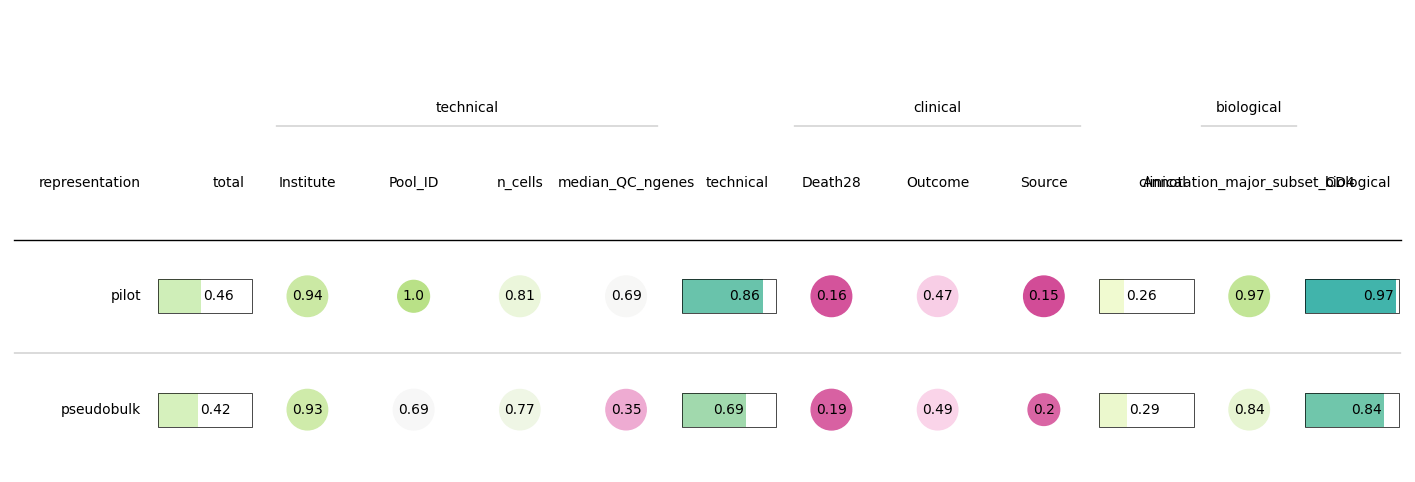

In [42]:
fig, ax = plt.subplots(figsize=(18, 6))

Table(knn_results_wide[cols_order].sort_values("total", ascending=False),
      column_definitions=tuple(col_defs), ax=ax)

# Other methods

There are other methods implemented that you might want to try:
- Per-cell type pseudobulk: `pr.tl.CellTypePseudobulk`
- Composition differences: `pr.tl.CellTypesComposition`
- scPoli: `pr.tl.SCPoli`
- MrVI: `pr.tl.MrVI`
- PhEMD: `pr.tl.PhEMD`
    - This implementation is very computationally intensive. You might want to leave 100-200 cells per patient to get results in a reasonable time. Use `pr.pp.subsample` for this
- Wasserstein distance between gaussians: `pr.tl.WassersteinTSNE`

There are also methods implemented in R. GloScope performs quite well. You can save layer you want to run it on (e.g. scVI or PCA representation of cells) to csv files and then run this script:

In [47]:
!cat ../../src/patient_representation/tl/gloscope.R

#!/usr/bin/env Rscript

# install.packages(c("optparse", "devtools"))
# devtools::install_github("epurdom/gloscope")

# Load required libraries
library(optparse)
library(GloScope)

# Define options and parse command-line arguments
option_list <- list(
  make_option(c("-d", "--df_path"), type="character", help="Path to the embedding DataFrame"),
  make_option(c("-s", "--sample_ids_path"), type="character", help="Path to the sample IDs"),
  make_option(c("-m", "--dist_mat"), default="KL", type="character", help="Distance matrix: 'KL' or 'JS'"),
  make_option(c("-n", "--dens"), default="GMM", type="character", help="Density estimation: 'GMM' or 'KNN'"),
  make_option(c("-k", "--k"), default=25, type="integer", help="Integer k for k-NN"),
  make_option(c("-r", "--seed"), default=0, type="integer", help="Random seed"),
  make_option(c("-o", "--output_path"), type="character", help="Path to the output file"),
  make_option(c("-v", "--verbose"), default=FALSE, action="store_true", help="Print

In [ ]:
# Save layer. For smaller computation time, subset variables (e.g. take first 10 PCs), when this is appropriate
layer = "X_pca"
pd.DataFrame(
    adata.obsm[layer],
    index=adata.obs_names,
    columns=[f"PCA_{i}" for i in range(adata.obsm[layer].shape[1])]
).to_csv(f"data/gloscope_{layer}.csv")

# Save samples
pd.DataFrame(
    adata.obs[sample_id_col]
).to_csv("data/combats_samples.csv", index=False)

In [ ]:
%%bash

GLOSCOPE_SCRIPT=../../src/patient_representation/src/patient_representation/tl/gloscope.R

Rscript ${GLOSCOPE_SCRIPT} \
    --df_path="data/combat_X_pca.csv" \
    --sample_ids_path="data/combat_samples.csv" \
    --dist_mat="KL" \
    --dens="KNN" \
    --k=25 \
    --seed=2 \
    --output="data/gloscope_output.csv" \
    -v;

# Compare KNN score for different patient subsets

In [ ]:
# init scPoli
scpoli_method = pr.tl.SCPoli(sample_key=sample_id_col, cells_type_key=cell_type_key, latent_dim=3, layer="X_raw_counts")
scpoli_method.prepare_anndata(adata, sample_size_threshold=100)

donor_counts = list(range(10, 139, 5))
num_runs = 20
results = pd.DataFrame(columns=["Method", "Number of Donors", "Score", "Run"])

for run in range(num_runs):
    for count in donor_counts:
        # TotalPseudobulk
        score_pseudobulk = pseudobulk.evaluate_representation(target="Outcome", method="knn", num_donors_subset=count, n_neighbors=5, task="ranking")
        results = results.append({"Method": "TotalPseudobulk", "Number of Donors": count, "Score": score_pseudobulk['score'], "Run": run}, ignore_index=True)
        
        # PILOT
        score_pilot = pilot.evaluate_representation(target="Outcome", method="knn", num_donors_subset=count, n_neighbors=5, task="ranking")
        results = results.append({"Method": "PILOT", "Number of Donors": count, "Score": score_pilot['score'], "Run": run}, ignore_index=True)

        #scPoli
        score_scPoli = pilot.evaluate_representation(target="Outcome", method="knn", num_donors_subset=count, n_neighbors=5, task="ranking")
        results = results.append({"Method": "scPoli", "Number of Donors": count, "Score": score_scPoli['score'], "Run": run}, ignore_index=True)

# Plotting the results 
plt.figure(figsize=(20, 10))
sns.boxplot(data=results, x="Number of Donors", y="Score", hue="Method")
sns.swarmplot(data=results, x="Number of Donors", y="Score", hue="Method", color=".25", dodge=True, size=3)

plt.title('KNN Score Distribution Across Donor Counts and Methods')
plt.xlabel('Number of Donors')
plt.ylabel('Spearman Score')
plt.grid(True)

handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(handles[:3], labels[:3], title="Method", loc='upper left') 

plt.savefig("knn_score_distribution.png", dpi=300)
plt.close()

Here is the "knn_score_distribution.png" output from the previous cell:

![knn_score_distribution](./knn_score_distribution.png)